# Diffusion anisotropy

## Import packages

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cage_data import cage1_info
from fishmol.utils import vector, Arrow3D, h_channel, calc_freq
from fishmol import msd
from fishmol import style

## Load water CoM data

In [2]:
water_com = pd.read_excel("test/cage1-500K-water-com.xlsx", header=0, index_col=0, engine = "openpyxl")
water_com.head()

,water1_x,water1_y,water1_z,water2_x,water2_y,water2_z,water3_x,water3_y,water3_z,water4_x,...,water5_z,water6_x,water6_y,water6_z,water7_x,water7_y,water7_z,water8_x,water8_y,water8_z
0,10.586316,19.902134,10.380009,0.624155,10.923925,8.298079,-1.967392,4.261146,12.241481,4.693672,...,4.725172,15.090375,8.649502,6.883228,17.759366,15.321196,2.865725,11.019290,3.578953,0.703805
1,10.597616,19.945151,10.393126,0.617881,10.942585,8.312331,-1.961926,4.253910,12.205821,4.689873,...,4.745156,15.076014,8.640429,6.849210,17.749958,15.278667,2.889409,11.049146,3.587807,0.663123
2,10.610208,20.003821,10.408405,0.610859,10.967922,8.330438,-1.953047,4.243309,12.156421,4.687198,...,4.767198,15.058083,8.628816,6.804086,17.738720,15.225162,2.920655,11.086905,3.600664,0.608757
3,10.622718,20.062112,10.416761,0.604688,10.993416,8.349495,-1.945208,4.229969,12.106099,4.687512,...,4.786539,15.040753,8.617851,6.760128,17.728982,15.181476,2.948253,11.122864,3.614650,0.558271
4,10.636664,20.122749,10.416813,0.597829,11.020753,8.373153,-1.941190,4.211549,12.054352,4.691621,...,4.808036,15.020218,8.605213,6.714651,17.717884,15.151479,2.970079,11.155729,3.629731,0.511643


## Calculate 1D diffusion coefficient on a spherical meshgrid

In [3]:
water_num = 8
vecs, ave_d = msd.proj_d(df = water_com, num = water_num)

Progress: [■■■■■■■■■■■■■■■■■■■■] 100.0%


In [4]:

data = np.concatenate((vecs, ave_d.reshape((len(vecs), 1))), axis = 1)
results = pd.DataFrame(columns = ["x", "y", "z", "mean_D"], data = data)
results.head()

,x,y,z,mean_D
0,1.224647e-16,-7.498799e-33,-1.000000,0.000017
1,5.277535e-02,-3.231558e-18,-0.998606,0.000018
2,1.054036e-01,-6.454109e-18,-0.994430,0.000019
3,1.577381e-01,-9.658671e-18,-0.987481,0.000020
4,2.096329e-01,-1.283631e-17,-0.977780,0.000022


In [5]:
results.to_excel("test/cage1-500K-aniso.xlsx")

In [6]:
cell= [
    [21.2944000000,        0.0000000000,        0.0000000000],
    [-4.6030371123,       20.7909480472,        0.0000000000],
    [-0.9719093466,       -1.2106211379,       15.1054299403]
]

diags = [[1,0,0],[0,1,0],[0,0,1]]
diags = [ vector(diag, cell = cell, name = "m") for diag in diags]

In [7]:
[diag.to_cart() for diag in diags]

In [12]:
x = vecs[:,0]*ave_d
y = vecs[:,1]*ave_d
z = vecs[:,2]*ave_d
# ave_d = data.iloc[:,3].to_numpy()

/tmp/ipykernel_3339671/2059225541.py:31: MatplotlibDeprecationWarning: The 'renderer' parameter of do_3d_projection() was deprecated in Matplotlib 3.4 and will be removed two minor releases later.
  plt.savefig("test/cage1-aniso-500K.jpg", dpi = 600)


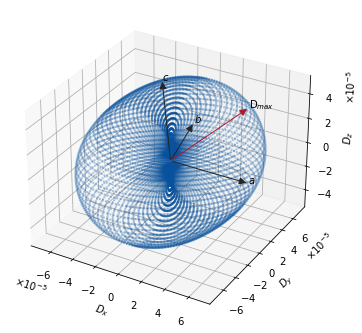

In [28]:
fig = plt.figure(figsize = (5, 4.6))
ax = fig.add_axes([0.0,0.04,0.90,0.96], projection='3d')

zdirs = (None,)*3
labels = ("$a$", "$b$", "$c$")

# ax.plot_trisurf(x, y, z, edgecolor ='none', cmap='PuBu', alpha=0.8)
ax.scatter3D(x, y, z, edgecolor ='none', marker = ".", color = "#08519c", alpha=0.3)

for i, axis in enumerate(diags):
    axis = axis.array/15000
    a = Arrow3D([0, axis[0]], [0, axis[1]], [0, axis[2]], mutation_scale=15, 
            lw=1, arrowstyle="-|>", color="#252525")
    ax.add_artist(a)
    ax.text(*axis, labels[i], zdirs[i])

idx = np.where(ave_d == np.amax(ave_d))
h_path = vecs[idx]*ave_d[idx]

a = Arrow3D(*zip(np.zeros(3), h_path[0]), mutation_scale=15, 
        lw=1, arrowstyle="-|>", color="#b2182b")
ax.add_artist(a)
ax.text(*h_path[0], "D$_{max}$", None)

ax.set_xlabel("$D_x$")
ax.set_ylabel("$D_y$")
ax.set_zlabel("$D_z$")

ax.ticklabel_format(axis='both', style='sci', scilimits=[-4,4], useMathText=True)

plt.savefig("test/cage1-aniso-500K.jpg", dpi = 600)

plt.show()

## Voroni method to identify the diffusion channel of water molecules

### Cage 1 500 K
The h-path is almost aligned with [100], and the following points used to devide channels 

In [30]:
points = np.asarray([
    (0, -3, -2), (0, -3, -1), (0, -3, 0), (0, -3, 1), (0, -3, 2), (0, -3, 3),
    (0, -2, -3), (0, -2, -2), (0, -2, -1), (0, -2, 0), (0, -2, 1), (0, -2, 2), (0, -2, 3),
    (0, -1, -3), (0, -1, -2), (0, -1, -1), (0, -1, 0), (0, -1, 1), (0, -1, 2), (0, -1, 3),
    (0, 0, -3), (0, 0, -2), (0, 0, -1), (0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3),
    (0, 1, -3), (0, 1, -2), (0, 1, -1), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3),
    (0, 2, -3), (0, 2, -2), (0, 2, -1), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3),
    (0, 3, -2), (0, 3, -1), (0, 3, 0), (0, 3, 1), (0, 3, 2), (0, 3, 3)
], dtype = np.float64)

cell = cage1_info.cell

# The coordination the points will be projected to new coordinate system, where w3 is the h_path with the highest proton diffusivity
w1 = vector([0, 1, 0], cell = cell, name = "m")
w2 = vector([0, 0, 1], cell = cell, name = "m")
w3 = vector([1, 0, 0], cell = cell, name = "m")

W = np.asarray([globals()[f'w{i + 1}'].array for i in range(3)])

In [31]:
points_arrs = [vector(point, cell = cell) for point in points]

In [32]:
for point_arr in points_arrs:
    point_arr.to_cart(normalise = False)

In [33]:
points = np.asarray([point.array for point in points_arrs])
points

array([[ 15.75293003, -59.95160187, -30.21085988],
       [ 14.78102068, -61.162223  , -15.10542994],
       [ 13.80911134, -62.37284414,   0.        ],
       [ 12.83720199, -63.58346528,  15.10542994],
       [ 11.86529264, -64.79408642,  30.21085988],
       [ 10.8933833 , -66.00470756,  45.31628982],
       [ 12.12180226, -37.95003268, -45.31628982],
       [ 11.14989292, -39.16065382, -30.21085988],
       [ 10.17798357, -40.37127496, -15.10542994],
       [  9.20607422, -41.58189609,   0.        ],
       [  8.23416488, -42.79251723,  15.10542994],
       [  7.26225553, -44.00313837,  30.21085988],
       [  6.29034618, -45.21375951,  45.31628982],
       [  7.51876515, -17.15908463, -45.31628982],
       [  6.54685581, -18.36970577, -30.21085988],
       [  5.57494646, -19.58032691, -15.10542994],
       [  4.60303711, -20.79094805,   0.        ],
       [  3.63112777, -22.00156919,  15.10542994],
       [  2.65921842, -23.21219032,  30.21085988],
       [  1.68730907, -24.42281

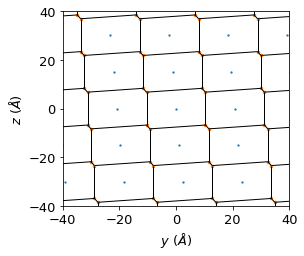

In [37]:
from scipy.spatial import voronoi_plot_2d
vor = h_channel(points[:,1:])
fig = voronoi_plot_2d(vor)
ax = plt.gca()
# ax.scatter([0],[0])

ax.set_xlim(-40,40)
ax.set_ylim(-40,40)

ax.set_xlabel("$y$ ($\AA$)")
ax.set_ylabel("$z$ ($\AA$)")
plt.show()